In [115]:
import os
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import UnivariateSpline
from plotnine import *
from collections import OrderedDict
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

In [3]:
name = "PRP"
names = ["ABH", "AEB", "CDH", "CDS", "COF1", "COF2", "EDS", "PRP"]


os.chdir("C:\\Users\\BERNARD-REYMONDGuill\\ENGIE\\Pôle Ressource et productible - 4-Stage\\2025 - Bernard-Reymond")

In [6]:

df_cons = pyreadr.read_r(f".\\2-Inputs\\{name}\\df_cons.rds")

# Données contenues dans l'OrderedDict
data = list(df_cons.values())[0]

# Conversion en DataFrame
df_cons = pd.DataFrame(data)


OrderedDict({None:      X   V     P    ct
0    1   3    20  0.98
1    2   4    94  0.87
2    3   5   205  0.79
3    4   6   391  0.79
4    5   7   645  0.79
5    6   8   979  0.79
6    7   9  1375  0.74
7    8  10  1795  0.69
8    9  11  2000  0.54
9   10  12  2040  0.39
10  11  13  2050  0.29
11  12  14  2050  0.23
12  13  15  2050  0.19
13  14  16  2050  0.15
14  15  17  2050  0.13
15  16  18  2050  0.11
16  17  19  2050  0.09
17  18  20  2050  0.08
18  19  21  2050  0.07
19  20  22  2050  0.06
20  21  23  2050  0.06
21  22  24  2050  0.05})


In [13]:
df_lidar = pyreadr.read_r(f".\\2-Inputs\\{name}\\df_lidar_filtered.rds")

# Données contenues dans l'OrderedDict
data = list(df_lidar.values())[0]

# Conversion en DataFrame
df_lidar = pd.DataFrame(data)

In [7]:
df_wrf = pyreadr.read_r(f".\\2-Inputs\\{name}\\df_wrf_filtered.rds")

data = list(df_wrf.values())[0]
df_wrf = pd.DataFrame(data)

df_wrf.head()

df_wrf_norm = df_wrf.copy()
df_wrf_norm['ws'] = df_wrf['ws'] * (288 /(df_wrf['temp']+273))**(1/3)
df_wrf_norm = df_wrf_norm.drop(columns='temp')

df_wrf_norm.head()

,TimeStamp,ws,wa,ti,shear
0,2003-01-01 00:00:00,3.168409,244.2,0.1013,0.044853
1,2003-01-01 01:00:00,2.719605,229.7,0.1179,0.052273
2,2003-01-01 02:00:00,3.437190,197.5,0.0932,-0.030626
3,2003-01-01 03:00:00,5.399640,178.0,0.0593,-0.115452
4,2003-01-01 04:00:00,8.462154,177.1,0.0475,0.063012


In [ ]:
#premier graphe
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(8,10))
ax[0].boxplot(x=df_wrf['ws'])
ax[1].scatter(data=df_wrf,x='ws',y='ti')
ax[2].hist(x=df_wrf['ti'],bins=30,density=True)
ax[0].set_xlabel('Vitesse')
ax[0].set_ylabel('Puissance')
ax[0].set_title(f'Courbe de puissance constructeur pour {name}')
plt.show()


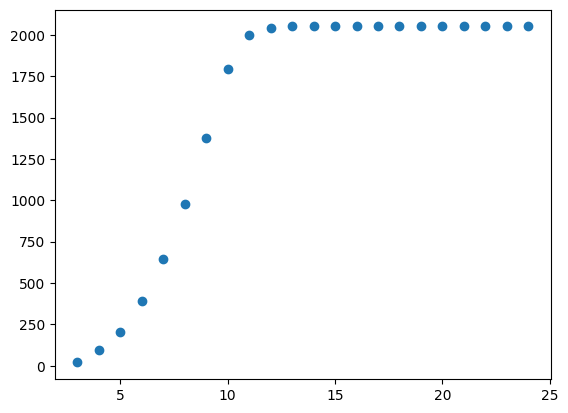

In [11]:

plt.plot('V',df_cons['P'],data=df_cons, linestyle='none', marker='o')
plt.show()


In [12]:

variables_lidar = ["ws_hub_norm","ti_hub","v_shear","v_veer"]
if (name in ["COF1","COF2"]):
    variables_mat = ["ws_mat","ti_mat" , "wa_mat"]
else:
    variables_mat = ["ws_mat","ti_mat" , "shear_mat","wa_mat"]

In [ ]:
def binning(x,y,start=0,stop=20,pas=0.5):
    breaks = np.arange(start, stop = np.ceil(x.max())+0.5,step=pas)
    bins = pd.cut(x,bins=breaks,right=False)
    
    df=pd.DataFrame({'bins':bins,
                         'y':y})
    agg = df.groupby('bins', observed=True, as_index=False)['y'].mean()

    all_bins = pd.cut(breaks[:-1],bins=breaks,right=False).categories
    centers = [(x.left + x.right)/2 for x in all_bins]

    df_bin = pd.DataFrame({'bins':all_bins,
                           'center':centers})
    df_bin = df_bin.merge(agg,on='bins',how='left').rename(columns={'y':'var'})

    valid = df_bin.dropna(subset=['var'])

    cp_bin_fun = UnivariateSpline(valid['center'], valid['var'], s=0.5)

    return {'df_bin': df_bin,
            'cp_bin_fun': cp_bin_fun
    }



In [73]:

res = binning(df_wrf['ws'],df_wrf['ti'])
res['df_bin']


,bins,center,var
0,"[0.0, 0.5)",0.25,1.690202
1,"[0.5, 1.0)",0.75,0.567066
2,"[1.0, 1.5)",1.25,0.348528
3,"[1.5, 2.0)",1.75,0.252057
4,"[2.0, 2.5)",2.25,0.199546
5,"[2.5, 3.0)",2.75,0.164037
6,"[3.0, 3.5)",3.25,0.138349
7,"[3.5, 4.0)",3.75,0.120567
8,"[4.0, 4.5)",4.25,0.108556
9,"[4.5, 5.0)",4.75,0.097605


In [70]:

def binning_curve(df = df_lidar, df_cons = df_cons, start = 0, stop = 20, pas = 0.5):
    x = df['ws_hub_norm']
    y = df['P']
    
    df_bin = binning(x,y,start,stop,pas)['df_bin']
    
    fig,ax = plt.subplots()
    scatter = ax.scatter(
     x=x,y=y,c=df['ti_hub']*100, cmap='Greens',edgecolors=None,s=10) 

    ax.plot(df_cons['V'],df_cons['P'],color="blue")

    ax.plot(df_bin['center'],df_bin['var'],color="red") 

    ax.legend(title='Courbes')

    cbar = plt.colorbar(scatter,ax=ax)
    cbar.set_label("TI Hub (%)")
    scatter.set_clim(0,30)

    ax.grid(True,linestyle = '--',alpha=0.5) 
    plt.show()



C:\Users\BERNARD-REYMONDGuill\AppData\Local\Temp\ipykernel_3948\395667286.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


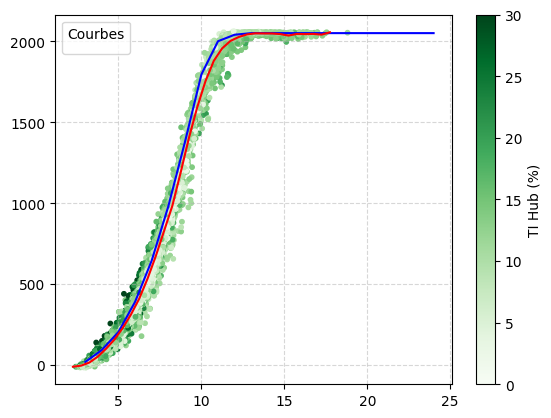

In [71]:
binning_curve(df=df_lidar,df_cons=df_cons)

In [98]:

def moy_filt(name,type="lidar"):
    if (type == "lidar"):
        df_ref = pyreadr.read_r(f".\\2-Inputs\\{name}\\df_lidar_filtered.rds")
        data = list(df_ref.values())[0]
        df_ref = pd.DataFrame(data)
    else:
        df_ref = pyreadr.read_r(f".\\2-Inputs\\{name}\\df_mat_filtered.rds")
        data = list(df_ref.values())[0]
        df_ref = pd.DataFrame(data)

    df_ref['TimeStamp'] = pd.to_datetime(df_ref['TimeStamp']) 
    df_ref['hour'] = df_ref['TimeStamp'].dt.floor('H')

    df_moy = (df_ref
              .groupby('hour')
              .filter(lambda x: len(x)==6)
              .groupby('hour')
              .mean(numeric_only=True)
              .round(2)
              .reset_index()
              .rename(columns={'hour':'TimeStamp'}))

    return df_moy
    

    
    
    
    

In [100]:
df_moy = moy_filt("PRP",type="lidar")

C:\Users\BERNARD-REYMONDGuill\AppData\Local\Temp\ipykernel_3948\4080506805.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


In [103]:
df_merge_wrf_lidar = df_wrf.merge(df_moy,on = "TimeStamp",how='inner')

In [104]:
df_merge_wrf_lidar.head()

,TimeStamp,ws,wa,temp,ti,shear,ws_hub_norm,ti_hub,v_shear,v_veer,P
0,2023-03-28 19:00:00,10.09,187.4,9.1,0.0508,0.224110,7.07,0.08,0.59,-0.03,684.40
1,2023-03-28 20:00:00,9.23,194.2,8.8,0.0484,0.462549,7.25,0.06,0.48,-0.05,688.68
2,2023-03-28 21:00:00,10.05,212.1,9.1,0.0580,0.445929,5.71,0.05,0.24,-0.22,323.51
3,2023-03-29 01:00:00,7.52,217.4,8.9,0.0447,0.458884,6.16,0.05,0.23,-0.38,311.85
4,2023-03-29 02:00:00,8.18,211.5,9.1,0.0572,0.390879,6.54,0.05,0.31,-0.34,406.85


In [124]:
def train_and_fit(variable, df_merge=df_merge_wrf_lidar,df_rea=df_wrf,shear="no"):
   if (shear=="no"):
      df_rea = df_rea.drop(['temp','shear'],axis=1)
   else:
      df_rea = df_rea.drop(['temp'],axis=1)
      
   X = df_merge_wrf_lidar[['ws','wa','ti']]
   y = df_merge_wrf_lidar[variable]

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1809) 
   
   cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1809)

   model = RandomForestRegressor(n_estimators=100,criterion='squared_error',n_jobs=-1,random_state=1809)
   
   param_grid = {
        'max_depth': [5, 10, 15, None]
    }

   grid_search = GridSearchCV(
      estimator = model,
      param_grid=param_grid,
      cv=cv,
      scoring='r2',
      n_jobs=-1,
      verbose=1
   )

   grid_search.fit(X_train,y_train)

   best_model = grid_search.best_estimator_
   
   y_pred = best_model.predict(X_test)
   r2 = r2_score(y_test, y_pred)
   rmse = root_mean_squared_error(y_test, y_pred)
   biais = np.mean(y_pred) - np.mean(y_test)

   results_fit = {f'fit_{variable}' : best_model}

   df_res = pd.DataFrame([{
        'var': variable,
        'r2': r2,
        'nrmse (%)' : rmse / np.mean(y_test)*100,
        'biais' : biais
    }])
   
   return df_res , results_fit






    
    
  


In [125]:
all_df_res = []                # liste pour les DataFrame de résultats R²
all_results_fit = {}           # dictionnaire pour stocker les modèles

for var in variables_lidar:
    df_res, results_fit = train_and_fit(
        variable=var,
        df_merge=df_merge_wrf_lidar,
        df_rea=df_wrf,
        shear="no"
    )
    
    all_df_res.append(df_res)                      # ajouter les résultats R²
    all_results_fit.update(results_fit)            # ajouter les modèles par variable

Fitting 15 folds for each of 4 candidates, totalling 60 fits
Fitting 15 folds for each of 4 candidates, totalling 60 fits
Fitting 15 folds for each of 4 candidates, totalling 60 fits
Fitting 15 folds for each of 4 candidates, totalling 60 fits


In [126]:
df_results_all = pd.concat(all_df_res, ignore_index=True)

In [127]:
df_results_all

,var,r2,nrmse (%),biais
0,ws_hub_norm,0.723016,18.719490,-0.084508
1,ti_hub,0.432892,27.853274,-0.001930
2,v_shear,0.241426,59.925209,-0.001029
3,v_veer,0.062317,-161.880475,-0.020682


In [143]:
X = df_merge_wrf_lidar[['ws','wa','ti']]
pred_ws_hub_norm = all_results_fit['fit_ws_hub_norm'].predict(X)
pred_ti_hub = all_results_fit['fit_ti_hub'].predict(X)

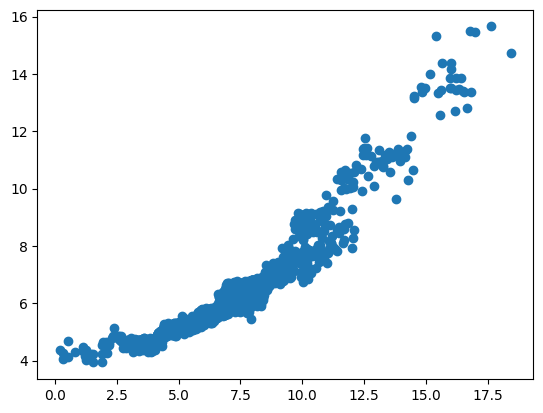

In [133]:
fig,ax = plt.subplots()
ax.scatter(df_merge_wrf_lidar['ws'],pred_ws_hub_norm)
plt.show()

In [148]:
var = "v_shear"
pred_shear = all_results_fit[f'fit_{var}'].predict(X)

In [154]:
df_SLT_lidar = pd.DataFrame({'TimeStamp' : df_wrf['TimeStamp']})
df_SLT_lidar.head()


,TimeStamp
0,2003-01-01 00:00:00
1,2003-01-01 01:00:00
2,2003-01-01 02:00:00
3,2003-01-01 03:00:00
4,2003-01-01 04:00:00


In [150]:
X = df_merge_wrf_lidar[['ws','wa','ti']]


In [156]:
for var in variables_lidar:
  print(var)
  df_SLT_lidar[var] = all_results_fit[f'fit_{var}'].predict(df_wrf[['ws','wa','ti']])

df_SLT_lidar.head()

ws_hub_norm
ti_hub
v_shear
v_veer


,TimeStamp,ws_hub_norm,ti_hub,v_shear,v_veer
0,2003-01-01 00:00:00,4.690570,0.069986,0.289174,-0.235891
1,2003-01-01 01:00:00,4.691408,0.066688,0.330267,-0.199014
2,2003-01-01 02:00:00,4.714554,0.074660,0.299533,-0.158555
3,2003-01-01 03:00:00,5.306711,0.066899,0.317802,-0.134455
4,2003-01-01 04:00:00,6.343252,0.060040,0.334974,-0.124597
